In [1]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import os
import sklearn
import sys

from graphviz import Source
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')

# to make this notebook's output stable across runs
np.random.seed(42)

RESULTS_PATH = os.path.join('./results')

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(RESULTS_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Loading the data

In [3]:
DATA_PATH = '../MLP2/input/'

# loading the audio file data
audio_df = pd.read_csv(DATA_PATH+'audio_data.csv') # we probably wont use this until we know how to neural network
audio_means_df = pd.read_csv(
    DATA_PATH + 'audio_means.csv')

# loading the .csv file data
song_dropped_df = pd.read_csv(
    DATA_PATH + 'dropped.csv')
song_filled_df = pd.read_csv(
    DATA_PATH + 'mean_filled.csv')

In [4]:
song_dropped_df = song_dropped_df.drop(columns=['artist_name','track_name','instance_id'])
song_filled_df = song_filled_df.drop(columns=['artist_name','track_name'])

In [5]:
keys = dict()
i = 0
for key in sorted(song_filled_df['key'].unique()):
    keys[key] = i
    i+=1

modes = dict({song_filled_df['mode'].unique()[0]:0, song_filled_df['mode'].unique()[1]:1})

In [6]:
#########################################################
### do we want to put this in the preprocessing file? ###
#########################################################
song_dropped_df['key'] = song_dropped_df['key'].apply(lambda x: keys[x])
song_dropped_df['mode'] = song_dropped_df['mode'].apply(lambda x: modes[x])

song_filled_df['key'] = song_filled_df['key'].apply(lambda x: keys[x])
song_filled_df['mode'] = song_filled_df['mode'].apply(lambda x: modes[x])

In [7]:
# getting a list of all genre names
audio_genres = audio_df['genre'].unique()
dropped_genres = song_dropped_df['music_genre'].unique()
filled_genres = song_filled_df['music_genre'].unique()

# getting a list of all features in each data frame
audio_features = audio_means_df.columns.drop('genre')
dropped_features = song_dropped_df.columns.drop('music_genre')
filled_features = song_filled_df.columns.drop('music_genre')

# Modeling

## Splitting the data

Separating data from labels

In [8]:
# audio data with means
X_audio = audio_means_df.loc[:, audio_means_df.columns != 'genre']
y_audio = audio_means_df['genre']

# song data with dropped null values
X_dropped = song_dropped_df.loc[:, song_dropped_df.columns != 'music_genre']
y_dropped = song_dropped_df['music_genre']

# song data with mean filled null values
X_filled = song_filled_df.loc[:, song_filled_df.columns != 'music_genre']
y_filled = song_filled_df['music_genre']

In [9]:
print(len(X_audio))
print(len(X_dropped))
print(len(X_filled))

1000
40560
50000


creating the initial splits

In [10]:
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
    X_audio, y_audio, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(
    X_dropped, y_dropped, test_size=0.30)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
    X_filled, y_filled, test_size=0.30)

In [11]:
y_audio_nums = y_audio.copy()
y_audio_nums.replace(audio_genres, [x for x in range(10)], inplace=True)

y_dropped_nums = y_dropped.copy()
y_dropped_nums.replace(dropped_genres, [x for x in range(10)], inplace=True)

y_filled_nums = y_filled.copy()
y_filled_nums.replace(filled_genres,[x for x in range(10)], inplace=True)

## Training

In [12]:
def run_grid_search(pipe, params, X, y, label):
    clf_GSCV = GridSearchCV(pipe, params)
    clf_GSCV.fit(X, y)
    df = pd.DataFrame(clf_GSCV.cv_results_)
    df['label'] = label
    return df

In [62]:
def plot_learning_curves(model, X, y, title=None, splits = [.05, .1, .15,.2, .25, .3, .35, .4], start_size = 1, plot_name = None, scale = 10):
    nrows = int(np.sqrt(len(splits)))
    ncols = int((len(splits)+1)/nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize = (18,8),sharey=True)
    i = 0
    # X_scaled = X.copy()
    # sc.fit(X_scaled)
    
    for split in splits:
        if nrows == 1:
            idx = i
        else:
            idx = (int(i / ncols), int(i % ncols))
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = split)
        train_errors, val_errors = [], []

        for m in range(start_size, len(X_train), scale):
            model.fit(X_train[:m ], y_train[:m ])
            y_train_predict = model.predict(X_train[:m ])
            y_val_predict = model.predict(X_val)
            train_errors.append(mean_squared_error(
                y_train[:m ], y_train_predict))
            val_errors.append(mean_squared_error(y_val, y_val_predict))

        axs[idx].set_title(f'test split size: {split}',fontsize = 14)
        axs[idx].plot(np.sqrt(train_errors), 'r--.', linewidth=0.5, label="train", markersize=3)
        axs[idx].plot(np.sqrt(val_errors), "b-", linewidth=2, label="test")
        axs[idx].legend(loc="upper right", fontsize=12)
        axs[idx].set_xlabel("Training set size", fontsize=12)
        axs[idx].set_ylabel("RMSE", fontsize=12)
        i += 1
    fig.suptitle(title, fontsize = 16)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.1,
                        hspace=0.4)
    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'learning_curves_' + plot_name + '.png'))

# plot_learning_curves(tree_dropped, X_dropped, y_dropped_nums,
#                      'Learning curves for decision tree model: dropped dataset', plot_name='tree_dropped', scale = 1000)


In [63]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(model, X, y, title=None, plot_name=None):
    fig, ax = plt.subplots(1, 1, figsize = (18,8),sharey=True)
    train_sizes = np.linspace(0.05, 0.8, 25)
    train_sizes, train_mse, test_mse = learning_curve(model, X, y,
                                                    train_sizes=train_sizes,
                                                    scoring='neg_root_mean_squared_error',
                                                    cv=3, shuffle=True)

    train_scores = np.sqrt(np.abs(train_mse))
    test_scores = np.sqrt(np.abs(test_mse))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    ax.set_title(f'test split size',fontsize = 14)
    ax.plot(train_sizes, train_scores_mean, 'o-',
            color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-',
            color="g", label="Cross-validation score")
    ax.legend(loc="best")

    fig.suptitle(title, fontsize = 16)

    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'learning_curve_' + plot_name + '.png'))

# plot_learning_curve(tree_dropped, X_dropped, y_dropped_nums,
#                      'Learning curves for decision tree model: dropped dataset', plot_name = = = m e ='learning_curve_tree_dropped.png')


In [64]:
def plot_confustion_matrices(models, plot_name):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    plot_confusion_matrix(
        models[0], X_audio_test, y_audio_test, ax=axs[0], cmap='magma')
    plot_confusion_matrix(
        models[1], X_dropped_test, y_dropped_test, ax=axs[1], cmap='magma')
    plot_confusion_matrix(
        models[2], X_filled_test, y_filled_test, ax=axs[2], cmap='magma')

    axs[0].set(title='Audio')
    axs[1].set(title='Dropped')
    axs[2].set(title='Filled')

    for i in range(3):
        axs[i].set_xticklabels(
            axs[i].get_xticklabels(),
            rotation=45,
            horizontalalignment='right'
        )
        axs[i].grid(False)

    plt.suptitle(
        f'Confusion matrices for {plot_name} models with optimal paramters',
        fontsize=16)

    plt.subplots_adjust(
        left=0.1,
        bottom=0.1,
        right=0.9,
        top=0.8,
        wspace=0.2,
        hspace=0.4)

    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'confusion_matrices_' + plot_name + '.png'))

In [67]:
# from sklearn.model_selection import learning_curve
# from sklearn.metrics import roc_curve, auc


# def plot_ROC_curves(model, X, y, title=None, splits=[.05, .1, .15, .2, .25, .3, .35, .4], plot_name=None):
#     nrows = int(np.sqrt(len(splits)))
#     ncols = int((len(splits) + 1) / nrows)
#     fig, axs = plt.subplots(nrows, ncols, figsize=(18, 8), sharey=True)
#     i = 0
#     # X_scaled = X.copy()
#     # sc.fit(X_scaled)

#     for split in splits:
#         if nrows == 1:
#             idx = i
#         else:
#             idx = (int(i / ncols), int(i % ncols))

#         X_train, X_test, y_train, y_test = train_test_split(
#             X, y, test_size=split)

#         y_score = model.predict_proba(X_test)

#         false_positive_rate, true_positive_rate, thresholds = roc_curve(
#             y_test, y_score[:, 1])

#         roc_auc = auc(false_positive_rate, true_positive_rate)

#         axs[idx].set_title(f'test split size: {split}', fontsize=14)
#         axs[idx].plot(false_positive_rate, true_positive_rate,
#                       label=('Accuracy = %0.2f' % roc_auc))
#         axs[idx].plot([0, 1], [0, 1], color='lightgrey', linestyle='--')
#         axs[idx].legend(loc="lower right", prop={'size': 8})
#         axs[idx].set_xlim([-0.05, 1.0])
#         axs[idx].set_ylim([0.0, 1.05])
#         axs[idx].set_ylabel('True Positive Rate')
#         axs[idx].set_xlabel('False Positive Rate')
#         i += 1
#     fig.suptitle(title, fontsize=16)
#     plt.subplots_adjust(left=0.1,
#                         bottom=0.1,
#                         right=0.9,
#                         top=0.9,
#                         wspace=0.1,
#                         hspace=0.4)
#     if plot_name:
#         plt.savefig(os.path.join(
#             RESULTS_PATH, 'ROC_curves_' + plot_name + '.png'))

# plot_ROC_curves(tree_dropped, X_dropped, y_dropped_nums,
#                      'ROC curves for decision tree model: dropped dataset', plot_name='tree_dropped', scale = 1000)



In [16]:
# defining the scaler we will be using
sc = StandardScaler()

### Decision Tree

In [46]:
tree = DecisionTreeClassifier()

tree_pipe = Pipeline(steps=[('sc', sc),
                       ('tree', tree)])

n_components = list(range(1, X_audio.shape[1] + 1, 1))

criterion = ['gini', 'entropy']
max_depth = [4, 6, 8, 10]

parameters = dict(
                  tree__criterion=criterion,
                  tree__max_depth=max_depth)
                  
tree_results_df = pd.DataFrame()
tree_results_df = tree_results_df.append(
    run_grid_search(tree_pipe, parameters, X_audio, y_audio, 'Audio')).append(
    run_grid_search(tree_pipe, parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_grid_search(tree_pipe, parameters, X_filled, y_filled, 'Filled'))


In [47]:
best_tree_audio = tree_results_df[(tree_results_df.rank_test_score == 1) &
                (tree_results_df.label == 'Audio')]

best_tree_dropped = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                  (tree_results_df.label == 'Dropped')]

best_tree_filled = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                    (tree_results_df.label == 'Filled')]

In [ ]:
print('best audio parameters:\n', '--criterion--\n',
      best_tree_audio.param_tree__criterion.values, '--max_depth--\n',
      best_tree_audio.param_tree__max_depth.values)

print('\n\nbest dropped parameters:\n', '--criterion--\n',
      best_tree_dropped.param_tree__criterion.values, '--max_depth--\n',
      best_tree_dropped.param_tree__max_depth.values)

print('\n\nbest filled parameters:\n', '--criterion--\n',
      best_tree_filled.param_tree__criterion.values, '--max_depth--\n',
      best_tree_filled.param_tree__max_depth.values)


In [49]:
tree_audio = DecisionTreeClassifier(
    criterion=best_tree_audio['param_tree__criterion'].values[0],
    max_depth=best_tree_audio['param_tree__max_depth'].values[0]).fit(X_audio_train, y_audio_train)

tree_dropped = DecisionTreeClassifier(
    criterion=best_tree_dropped['param_tree__criterion'].values[0],
    max_depth=best_tree_dropped['param_tree__max_depth'].values[0]).fit(X_dropped_train, y_dropped_train)

tree_filled = DecisionTreeClassifier(
    criterion=best_tree_filled['param_tree__criterion'].values[0],
    max_depth=best_tree_filled['param_tree__max_depth'].values[0]).fit(X_filled_train, y_filled_train)

y_pred_audio = tree_audio.predict(X_audio_test)
y_pred_dropped = tree_dropped.predict(X_dropped_test)
y_pred_filled = tree_filled.predict(X_filled_test)

In [ ]:
plot_confustion_matrices([tree_audio, tree_dropped, tree_filled], 'tree')

In [21]:
result_metrics_audio = classification_report(y_audio_test, y_pred_audio)
result_metrics_dropped = classification_report(y_dropped_test, y_pred_dropped)
result_metrics_filled = classification_report(y_filled_test, y_pred_filled)

print('\n\nAudio\n', result_metrics_audio)
print('\n\nDropped\n', result_metrics_dropped)
print('\n\nFilled\n',result_metrics_filled)



Audio
               precision    recall  f1-score   support

       blues       0.14      0.05      0.07        21
   classical       0.69      0.41      0.51        22
     country       0.18      0.13      0.15        23
       disco       0.28      0.33      0.31        27
      hiphop       0.17      0.31      0.22        13
        jazz       0.17      0.24      0.20        21
       metal       0.31      0.62      0.41        13
         pop       0.56      0.75      0.64        20
      reggae       0.27      0.20      0.23        15
        rock       0.23      0.12      0.16        25

    accuracy                           0.30       200
   macro avg       0.30      0.32      0.29       200
weighted avg       0.30      0.30      0.28       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.36      0.32      0.33      1199
       Anime       0.72      0.69      0.70      1273
       Blues       0.49      0.47      0.48      1217
   C

In [22]:
dot_data = export_graphviz(
    tree_audio,
    rounded=True,
    filled=True,
    feature_names=audio_features,
    class_names=audio_genres
)

out_file = os.path.join(RESULTS_PATH, "audio_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"65,50!"')
pydot_graph.write_pdf(out_file)
# Source(pydot_graph.to_string())

True

In [23]:
dot_data = export_graphviz(
    tree_dropped,
    rounded=True,
    filled=True,
    feature_names=dropped_features,
    class_names=dropped_features
)

out_file = os.path.join(RESULTS_PATH, "dropped_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
# Source(pydot_graph.to_string())

True

In [24]:
dot_data = export_graphviz(
    tree_filled,
    rounded=True,
    filled=True,
    feature_names=filled_features,
    class_names=filled_features
)
out_file = os.path.join(RESULTS_PATH, "filled_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
# Source(pydot_graph.to_string())

True

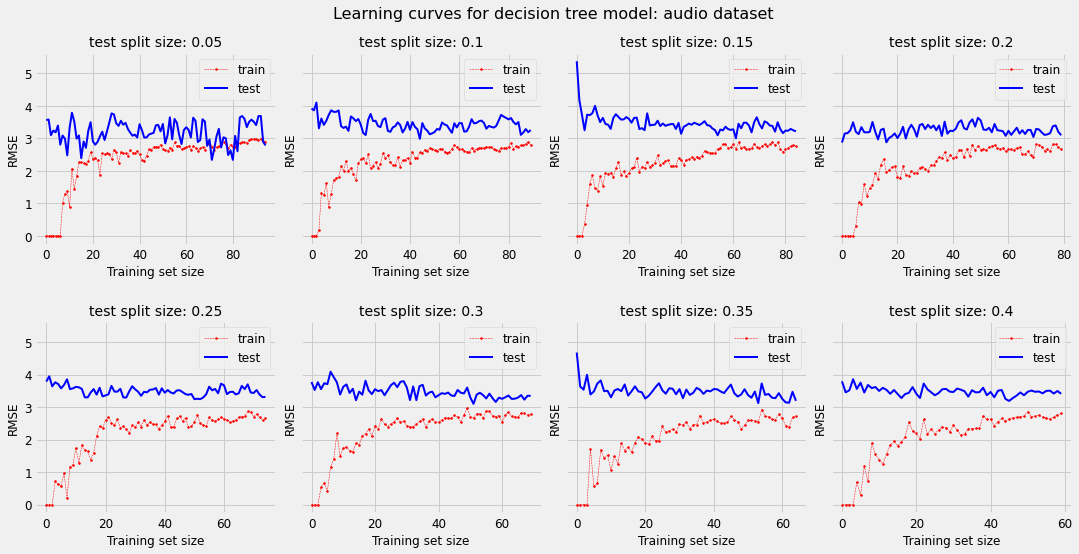

In [25]:
plot_learning_curves(tree_audio, X_audio, y_audio_nums,
                     'Learning curves for decision tree model: audio dataset', plot_name = 'tree_audio')

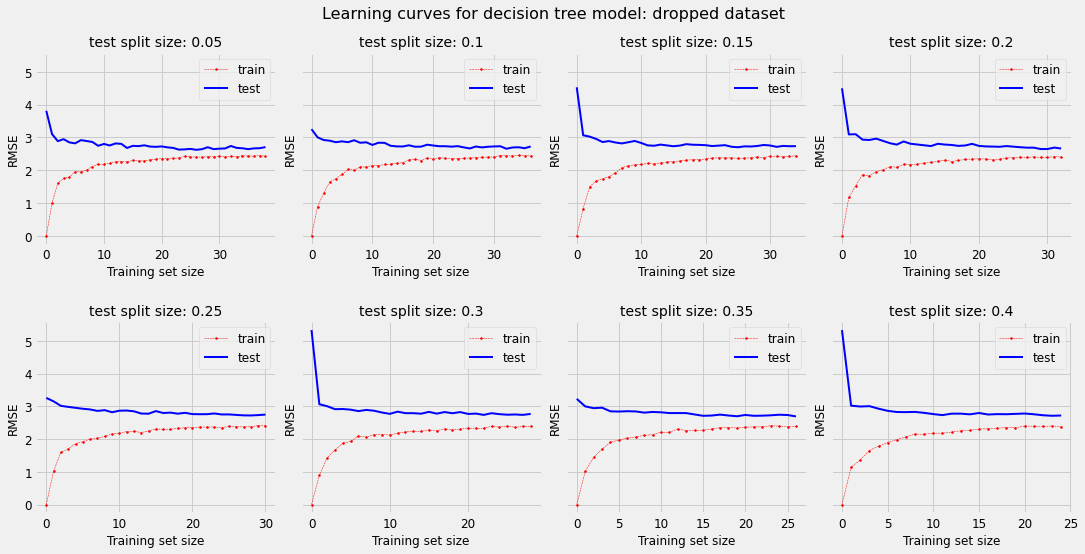

In [27]:
plot_learning_curves(tree_dropped, X_dropped, y_dropped_nums,
                     'Learning curves for decision tree model: dropped dataset', plot_name = 'tree_dropped', scale = 1000)

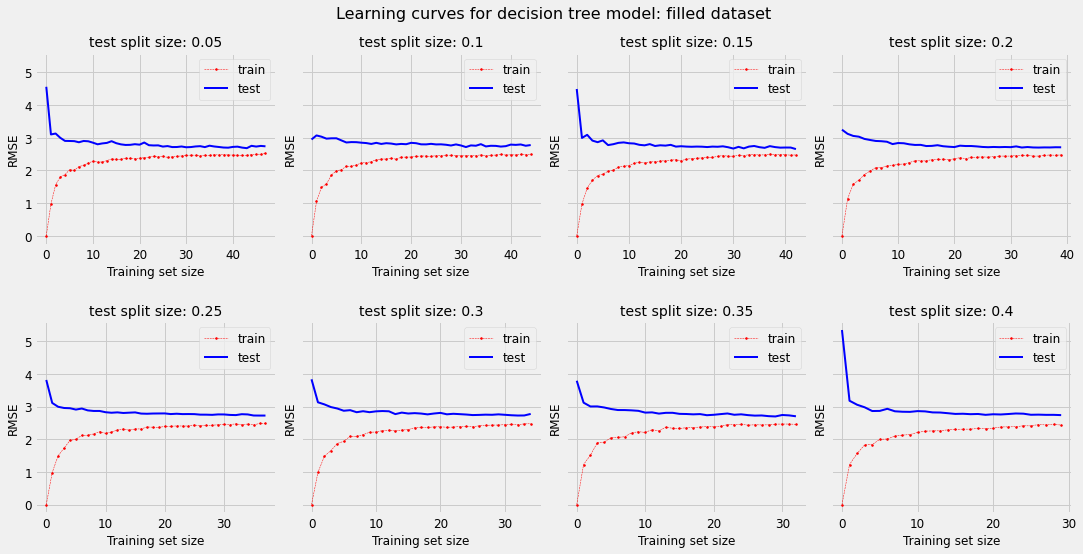

In [28]:
plot_learning_curves(tree_filled, X_filled, y_filled_nums,
                     'Learning curves for decision tree model: filled dataset', plot_name = 'tree_filled', scale = 1000)

### kNN Classifier

In [29]:
sc = StandardScaler()
knn = KNeighborsClassifier()

knn_pipe = Pipeline(steps=[('sc', sc),
                       ('knn', knn)])

n_components = list(range(1, X_audio.shape[1] + 1, 1))

neighbor_counts = [5, 10, 20, 30, 50]

parameters = dict(knn__n_neighbors=neighbor_counts)

knn_results_df = pd.DataFrame()
knn_results_df = knn_results_df.append(
    run_grid_search(knn_pipe, parameters, X_audio, y_audio, 'Audio')).append(
    run_grid_search(knn_pipe, parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_grid_search(knn_pipe, parameters, X_filled, y_filled, 'Filled'))


In [30]:
knn_results_df.reset_index(inplace=True, drop=True)


In [31]:
best_knn_audio = knn_results_df[(knn_results_df.rank_test_score == 1) &
                                (knn_results_df.label == 'Audio')]

best_knn_dropped = knn_results_df[(knn_results_df.rank_test_score == 1) &
                                  (knn_results_df.label == 'Dropped')]

best_knn_filled = knn_results_df[(knn_results_df.rank_test_score == 1) &
                                 (knn_results_df.label == 'Filled')]


In [ ]:
print('best audio parameters:\n', '--n_neighbors--\n',
      best_knn_audio.param_knn__n_neighbors.values)

print('\n\nbest dropped parameters:\n', '--n_neighbors--\n',
      best_knn_dropped.param_knn__n_neighbors.values)

print('\n\nbest filled parameters:\n', '--n_neighbors--\n',
      best_knn_filled.param_knn__n_neighbors.values)


In [32]:
knn_audio = KNeighborsClassifier(n_neighbors=best_knn_audio['param_knn__n_neighbors'].values[0]).fit(
    X_audio_train, y_audio_train)
knn_dropped = KNeighborsClassifier(
    n_neighbors=best_knn_dropped['param_knn__n_neighbors'].values[0]).fit(X_dropped_train, y_dropped_train)
knn_filled = KNeighborsClassifier(n_neighbors=best_knn_filled['param_knn__n_neighbors'].values[0]).fit(
    X_filled_train, y_filled_train)

y_pred_knn_audio = knn_audio.predict(X_audio_test)
y_pred_knn_dropped = knn_dropped.predict(X_dropped_test)
y_pred_knn_filled = knn_filled.predict(X_filled_test)

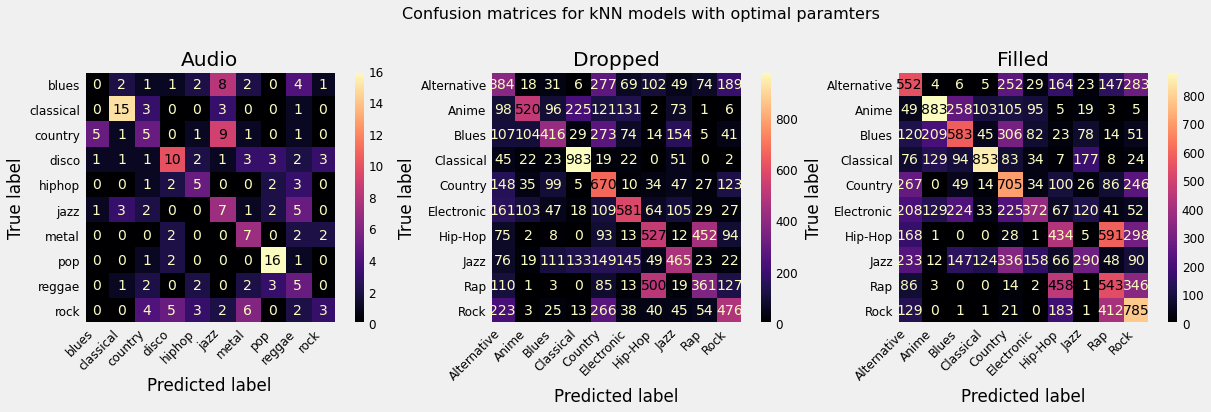

In [33]:
plot_confustion_matrices([knn_audio, knn_dropped, knn_filled], 'knn')

In [34]:
result_metrics_audio = classification_report(y_audio_test, y_pred_knn_audio)
result_metrics_dropped = classification_report(
    y_dropped_test, y_pred_knn_dropped)
result_metrics_filled = classification_report(y_filled_test, y_pred_knn_filled)

print('\n\nAudio\n', result_metrics_audio)
print('\n\nDropped\n', result_metrics_dropped)
print('\n\nFilled\n',result_metrics_filled)



Audio
               precision    recall  f1-score   support

       blues       0.00      0.00      0.00        21
   classical       0.65      0.68      0.67        22
     country       0.25      0.22      0.23        23
       disco       0.45      0.37      0.41        27
      hiphop       0.33      0.38      0.36        13
        jazz       0.23      0.33      0.27        21
       metal       0.32      0.54      0.40        13
         pop       0.62      0.80      0.70        20
      reggae       0.19      0.33      0.24        15
        rock       0.33      0.12      0.18        25

    accuracy                           0.36       200
   macro avg       0.34      0.38      0.35       200
weighted avg       0.35      0.36      0.34       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.27      0.32      0.29      1199
       Anime       0.63      0.41      0.50      1273
       Blues       0.48      0.34      0.40      1217
   C

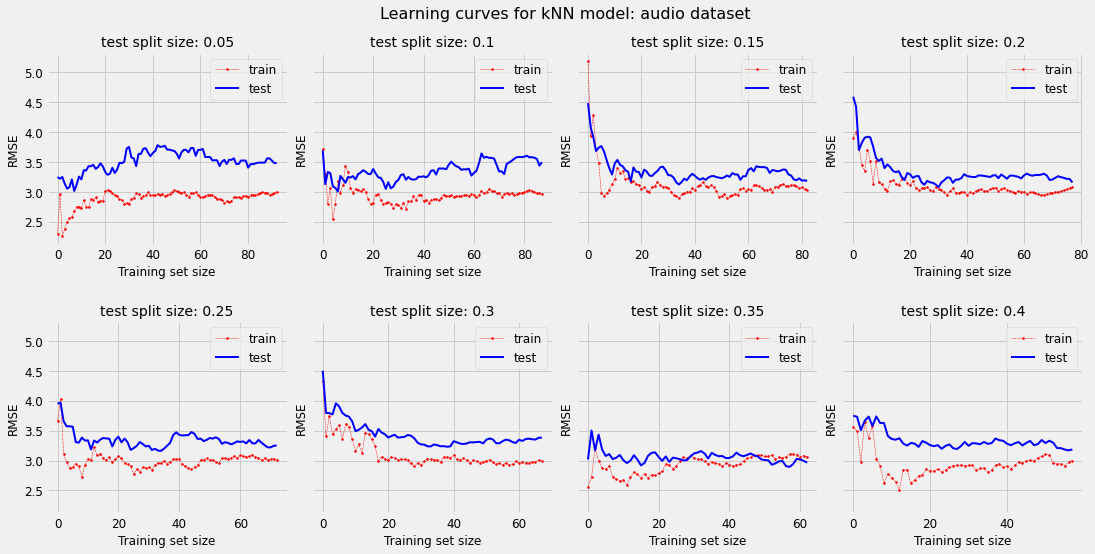

In [35]:
plot_learning_curves(knn_audio, X_audio, y_audio_nums,
                     'Learning curves for kNN model: audio dataset', start_size=best_knn_audio['param_knn__n_neighbors'].values[0])

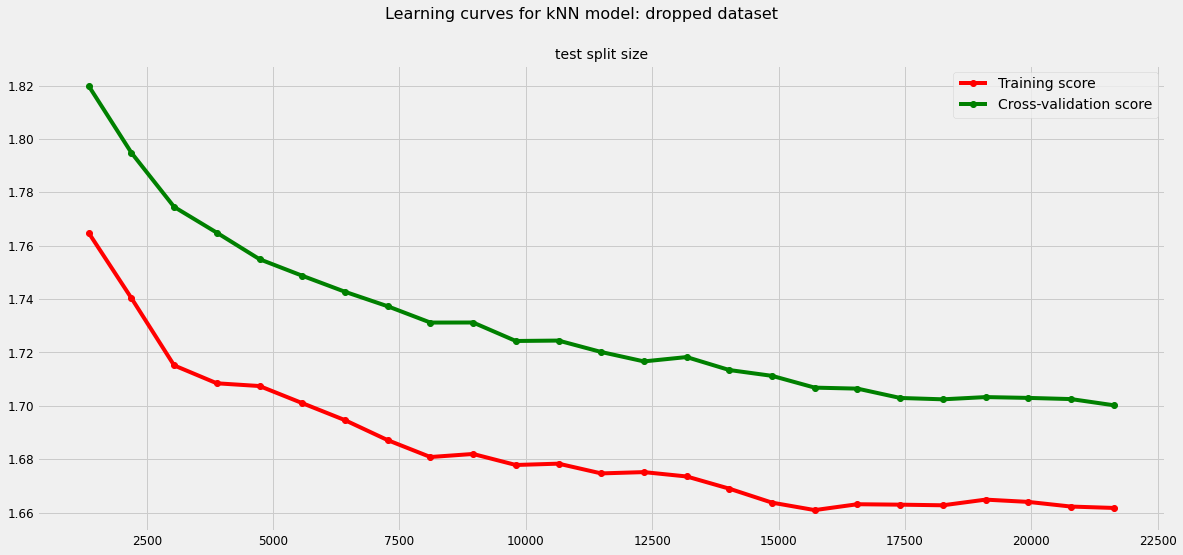

In [42]:
# plot_learning_curves(knn_dropped, X_dropped, y_dropped_nums,
                    #  'Learning curves for kNN model: dropped dataset', plot_name='knn_dropped', start_size=best_knn_dropped['param_knn__n_neighbors'].values[0], scale=4000)
plot_learning_curve(knn_dropped, X_dropped, y_dropped_nums,'Learning curves for kNN model: dropped dataset', plot_name='knn_dropped')


In [ ]:
plot_learning_curve(knn_filled, X_filled, y_filled_nums,
                     'Learning curves for kNN model: filled dataset', plot_name='knn_filled')

### Logistic Regression

In [53]:
sc = StandardScaler()
logreg = LogisticRegression()

logreg_pipe = Pipeline(steps=[('sc', sc),
                       ('logreg', logreg)])

solvers = ['lbfgs','liblinear','newton-cg']

max_iters = [100, 1000, 10000]

parameters = dict(logreg__solver=solvers,logreg__max_iter=max_iters)

logreg_results_df = pd.DataFrame()
logreg_results_df = logreg_results_df.append(
    run_grid_search(logreg_pipe, parameters, X_audio, y_audio, 'Audio')).append(
    run_grid_search(logreg_pipe, parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_grid_search(logreg_pipe, parameters, X_filled, y_filled, 'Filled'))


/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
best_logreg_audio = logreg_results_df[(logreg_results_df.rank_test_score == 1) &
                                      (logreg_results_df.label == 'Audio')]

best_logreg_dropped = logreg_results_df[(logreg_results_df.rank_test_score == 1) &
                                     (logreg_results_df.label == 'Dropped')]

best_logreg_filled = logreg_results_df[(logreg_results_df.rank_test_score == 1) &
                                       (logreg_results_df.label == 'Filled')]

In [55]:
print('best audio parameters:\n', '--max_iter--\n', best_logreg_audio.param_logreg__max_iter.values,
      '\n--solver--\n', best_logreg_audio.param_logreg__solver.values[0])

print('\n\nbest dropped parameters:\n', '--max_iter--\n', best_logreg_dropped.param_logreg__max_iter.values,
      '\n--solver--\n', best_logreg_dropped.param_logreg__solver.values[0])

print('\n\nbest filled parameters:\n', '--max_iter--\n', best_logreg_filled.param_logreg__max_iter.values,
      '\n--solver--\n', best_logreg_filled.param_logreg__solver.values[0])

best audio parameters:
 --max_iter--
 [100 100 1000 1000 10000 10000 100000 100000 1000000 1000000] 
--solver--
 lbfgs


best dropped parameters:
 --max_iter--
 [100 1000 10000 100000 1000000] 
--solver--
 newton-cg


best filled parameters:
 --max_iter--
 [1000 10000 100000 1000000] 
--solver--
 lbfgs


In [56]:
logreg_audio = LogisticRegression(solver=best_logreg_audio['param_logreg__solver'].values[0], max_iter=best_logreg_audio['param_logreg__max_iter'].values[0]).fit(
    X_audio_train, y_audio_train)
logreg_dropped = LogisticRegression(
    solver=best_logreg_dropped['param_logreg__solver'].values[0], max_iter=best_logreg_dropped['param_logreg__max_iter'].values[0]).fit(X_dropped_train, y_dropped_train)
logreg_filled = LogisticRegression(solver=best_logreg_filled['param_logreg__solver'].values[0], max_iter=best_logreg_filled['param_logreg__max_iter'].values[0]).fit(
    X_filled_train, y_filled_train)

y_pred_logreg_audio = logreg_audio.predict(X_audio_test)
y_pred_logreg_dropped = logreg_dropped.predict(X_dropped_test)
y_pred_logreg_filled = logreg_filled.predict(X_filled_test)

/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


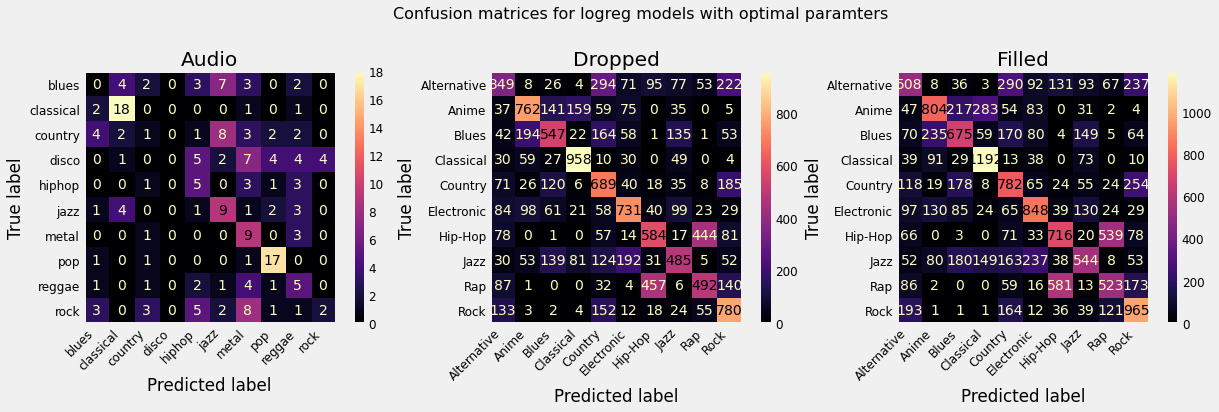

In [57]:
plot_confustion_matrices(
    [logreg_audio, logreg_dropped, logreg_filled], 'logreg')


In [58]:
result_metrics_audio = classification_report(y_audio_test, y_pred_logreg_audio)
result_metrics_dropped = classification_report(
    y_dropped_test, y_pred_logreg_dropped)
result_metrics_filled = classification_report(y_filled_test, y_pred_logreg_filled)

print('\n\nAudio\n', result_metrics_audio)
print('\n\nDropped\n', result_metrics_dropped)
print('\n\nFilled\n',result_metrics_filled)

/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Audio
               precision    recall  f1-score   support

       blues       0.00      0.00      0.00        21
   classical       0.62      0.82      0.71        22
     country       0.10      0.04      0.06        23
       disco       0.00      0.00      0.00        27
      hiphop       0.23      0.38      0.29        13
        jazz       0.31      0.43      0.36        21
       metal       0.23      0.69      0.34        13
         pop       0.61      0.85      0.71        20
      reggae       0.21      0.33      0.26        15
        rock       0.33      0.08      0.13        25

    accuracy                           0.33       200
   macro avg       0.26      0.36      0.28       200
weighted avg       0.26      0.33      0.27       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.37      0.29      0.33      1199
       Anime       0.63      0.60      0.62      1273
       Blues       0.51      0.45      0.48      1217
   C

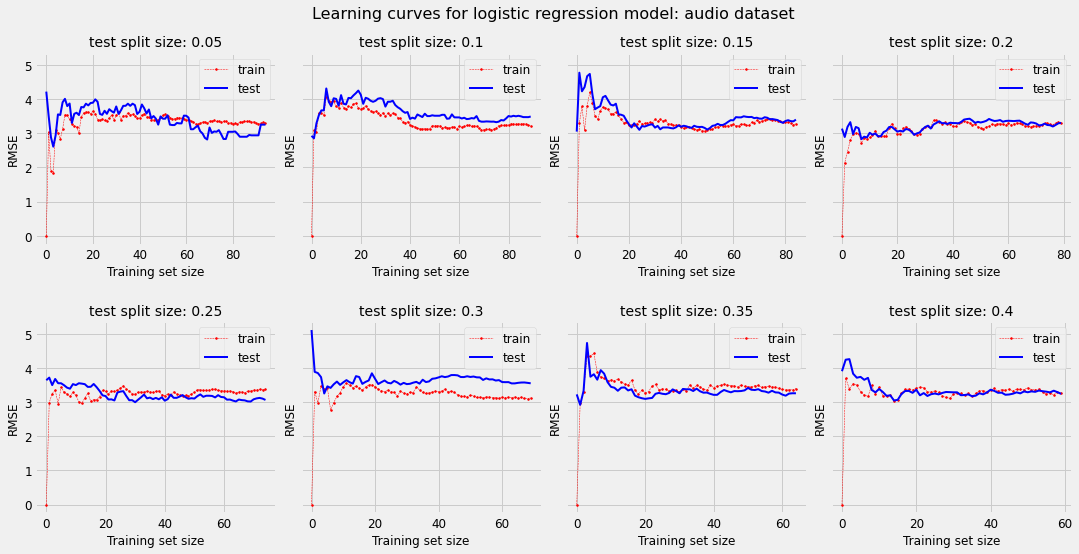

In [59]:
plot_learning_curves(logreg_audio, X_audio, y_audio_nums,
                     'Learning curves for logistic regression model: audio dataset', start_size=2)

In [ ]:
plot_learning_curves(logreg_dropped, X_dropped, y_dropped_nums,
                     'Learning curves for logistic regression model: dropped dataset', plot_name = 'logreg_dropped',scale=4000, start_size = 2)

In [ ]:
plot_learning_curves(logreg_filled, X_filled, y_filled_nums,
                     'Learning curves for logistic regression model: filled dataset', plot_name='logreg_filled', scale=4000, start_size=2)


### Random Forest

In [70]:
forest = RandomForestClassifier()

forest_pipe = Pipeline(steps=[('sc', sc),
                       ('forest', forest)])

n_estimators = [10, 50, 100, 200]
# We determined entropy was optimal from the decision tree modeling
criterion = ['entropy']
# We determined 10 was optimal from the decision tree modeling
max_depth = [10]

forest_parameters = dict(forest__n_estimators=n_estimators,
                  forest__criterion=criterion,
                  forest__max_depth=max_depth)

forest_results_df = pd.DataFrame()
forest_results_df = forest_results_df.append(
    run_grid_search(forest_pipe, forest_parameters, X_audio, y_audio, 'Audio')).append(
    run_grid_search(forest_pipe, forest_parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_grid_search(forest_pipe, forest_parameters, X_filled, y_filled, 'Filled'))

In [71]:
best_forest_audio = forest_results_df[(forest_results_df.rank_test_score == 1) &
                                      (forest_results_df.label == 'Audio')]

best_forest_dropped = forest_results_df[(forest_results_df.rank_test_score == 1) &
                                        (forest_results_df.label == 'Dropped')]

best_forest_filled = forest_results_df[(forest_results_df.rank_test_score == 1) &
                                       (forest_results_df.label == 'Filled')]

In [ ]:
print('best audio parameters:\n', '--n_estimators--\n', best_forest_audio.param_forest__n_estimators.values)
print('\n\nbest dropped parameters:\n', '--n_estimators--\n', best_logreg_dropped.param_forest__n_estimators.values)
print('\n\nbest filled parameters:\n', '--n_estimators--\n', best_logreg_filled.param_forest__n_estimators.values)


In [73]:
forest_audio = RandomForestClassifier(
    n_estimators=best_forest_audio['param_forest__n_estimators'].values[0],
    criterion=best_forest_audio['param_forest__criterion'].values[0],
    max_depth=best_forest_audio['param_forest__max_depth'].values[0]).fit(X_audio_train, y_audio_train)

forest_dropped = RandomForestClassifier(
    n_estimators=best_forest_dropped['param_forest__n_estimators'].values[0],
    criterion=best_forest_dropped['param_forest__criterion'].values[0],
    max_depth=best_forest_dropped['param_forest__max_depth'].values[0]).fit(X_dropped_train, y_dropped_train)

forest_filled = RandomForestClassifier(
    n_estimators=best_forest_filled['param_forest__n_estimators'].values[0],
    criterion=best_forest_filled['param_forest__criterion'].values[0],
    max_depth=best_forest_filled['param_forest__max_depth'].values[0]).fit(X_filled_train, y_filled_train)


y_pred_forest_audio = forest_audio.predict(X_audio_test)
y_pred_forest_dropped = forest_dropped.predict(X_dropped_test)
y_pred_forest_filled = forest_filled.predict(X_filled_test)

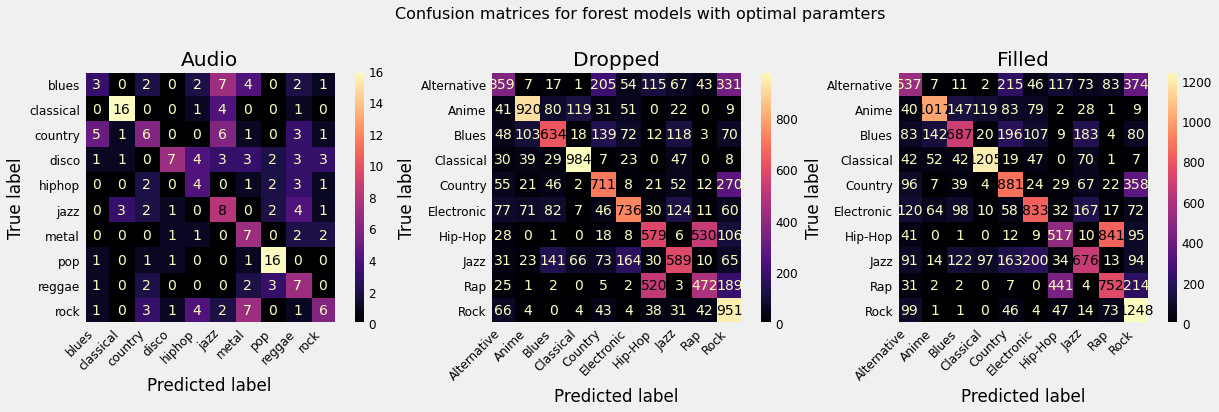

In [74]:
plot_confustion_matrices(
    [forest_audio, forest_dropped, forest_filled], 'forest')


In [75]:
forest_result_metrics_audio = classification_report(y_audio_test, y_pred_forest_audio)
forest_result_metrics_dropped = classification_report(y_dropped_test, y_pred_forest_dropped)
forest_result_metrics_filled = classification_report(y_filled_test, y_pred_forest_filled)

print('\n\nAudio\n', forest_result_metrics_audio)
print('\n\nDropped\n', forest_result_metrics_dropped)
print('\n\nFilled\n', forest_result_metrics_filled)



Audio
               precision    recall  f1-score   support

       blues       0.25      0.14      0.18        21
   classical       0.76      0.73      0.74        22
     country       0.33      0.26      0.29        23
       disco       0.64      0.26      0.37        27
      hiphop       0.25      0.31      0.28        13
        jazz       0.27      0.38      0.31        21
       metal       0.27      0.54      0.36        13
         pop       0.64      0.80      0.71        20
      reggae       0.27      0.47      0.34        15
        rock       0.40      0.24      0.30        25

    accuracy                           0.40       200
   macro avg       0.41      0.41      0.39       200
weighted avg       0.43      0.40      0.39       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.47      0.30      0.37      1199
       Anime       0.77      0.72      0.75      1273
       Blues       0.61      0.52      0.56      1217
   C

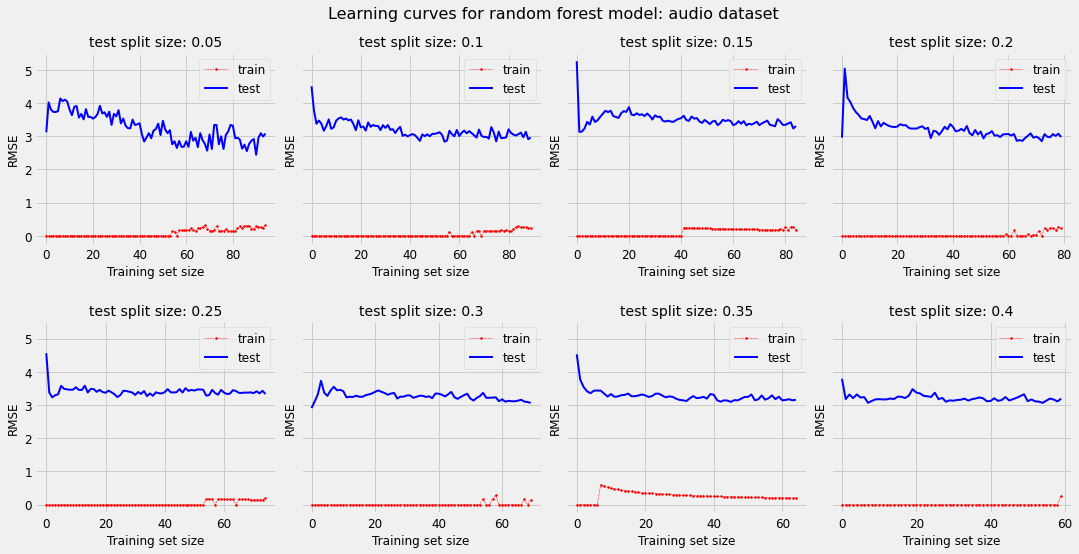

In [76]:
plot_learning_curves(forest_audio, X_audio, y_audio_nums,
                     'Learning curves for random forest model: audio dataset')

In [ ]:
plot_learning_curve(forest_dropped, X_dropped, y_dropped_nums,
                     'Learning curves for random forest model: dropped dataset', plot_name = 'forest_dropped')

In [ ]:
plot_learning_curve(forest_filled, X_filled, y_filled_nums,
                     'Learning curves for random forest model: filled dataset', plot_name='forest_filled')